In [1]:
import os
import sys

sys.path.append(os.getcwd())
from MLConnectedWorldBook.src import tmdb_graph
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import networkx as nx
from importlib import reload
import json
import numpy as np
from scipy.stats import ecdf
import matplotlib
import graph_utils
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, matthews_corrcoef

reload(tmdb_graph)
%matplotlib inline

In [2]:
dir_data = os.path.abspath(os.path.join(os.getcwd(),  'data/cit-HepTh'))
assert os.path.exists(dir_data)

In [3]:
os.listdir(dir_data)

['cit-HepTh-abstracts.tar.gz',
 'dates.txt',
 'ca-HepPh.txt.gz',
 'abstracts',
 'cit-HepTh.txt.gz',
 'text.txt',
 'cit-HepTh-dates.txt.gz']

In [4]:
fn_citations = os.path.join(dir_data, 'cit-HepTh.txt.gz')
fn_coauthors = "/Users/boris/Documents/teaching/ML on graphs/MLConnectedWorld/MLConnectedWorldBook/data/cit-HepTh/ca-HepPh.txt.gz"

In [5]:
import gzip
with gzip.open(fn_coauthors, 'rt') as f:
    lines = f.readlines()
lines = [l.strip().split() for l in lines if l[0] != '#']
df_coauthors = pd.DataFrame(lines, columns=['source', 'target'])
np.random.seed(42)
df_coauthors = df_coauthors.sample(frac=0.05).copy()

In [6]:
df_coauthors

,source,target
121644,24927,3362
230911,510,88051
3063,12665,36228
3442,39113,84543
67755,65894,51214
...,...,...
3287,39113,37722
115575,12011,3919
128631,55482,34644
202572,14715,22311


In [7]:
g = nx.from_pandas_edgelist(df_coauthors, 'source', 'target')
print(g)
g = graph_utils.get_connected_component_subgraphs(g)[0]
print(g)

Graph with 5842 nodes and 11553 edges
Graph named 'Component 1 of ' with 3849 nodes and 10166 edges


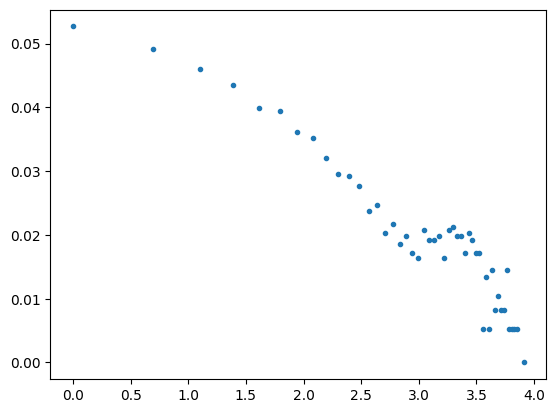

In [8]:
# log-log plot of the degree distribution
fig, ax = plt.subplots()
log_degrees = np.log(np.array([d for n, d in g.degree]))
log_counts = np.log(pd.Series(log_degrees).value_counts().sort_index())
log_freq = log_counts / log_counts.sum()
ax.plot(log_counts.index, log_freq, '.')

In [9]:
# now, we will introduce some abiguity in the graph
np.random.seed(42)
all_author_ids = set(df_coauthors['source']).union(set(df_coauthors['target']))
frac_noise = 0.005
n_noise = int(frac_noise * len(all_author_ids))

scrambled = dict()

for i in range(n_noise):
    n_to_scramble = np.random.randint(2, 4)
    scrambled_name = f'scrambled_{i:02d}'
    nodes_to_scramble = []
    while len(nodes_to_scramble) < n_to_scramble:
        node = np.random.choice(list(all_author_ids))
        if node not in scrambled:
            scrambled[node] = scrambled_name
            nodes_to_scramble.append(node)
            
    

In [10]:
df_scrambled = df_coauthors.copy()
df_scrambled['source'] = df_scrambled['source'].apply(lambda x: scrambled.get(x, x))
df_scrambled['target'] = df_scrambled['target'].apply(lambda x: scrambled.get(x, x))
g_scrambled = nx.from_pandas_edgelist(df_scrambled, 'source', 'target')
# add `scrambled` attribute to the nodes
for node in g_scrambled.nodes:
    g_scrambled.nodes[node]['scrambled'] = node.startswith('scrambled')

In [11]:
nx.write_graphml(g_scrambled, '/Users/boris/temp/graph_scrambled.graphml')

To build a classifier that can distinguish between the original and the scrambled nodes, we will use the following features:
- the degree of the node
- the clustering coefficient of the node
- the number of triangles the node is part of
- the number of triangles the node is part of that are not part of any other triangle
- node centrality measures: betweenness, closeness, eigenvector


In [12]:

def compute_node_features(g)->pd.DataFrame:
    # approx 2 minutes of computation time on the full dataset
    degrees = dict(g.degree)
    clustering = nx.clustering(g)
    triangles = nx.triangles(g)
    triangles_no_others = dict()
    n_depth_2 = dict()
    n_depth_4 = dict()
    for node in tqdm(g.nodes, total=len(g.nodes), leave=False):
        triangles_no_others[node] = sum([1 for n in g.neighbors(node) if n in triangles and triangles[n] == 1])
        n_depth_2[node] = len(set(nx.single_source_shortest_path_length(g, node, cutoff=2)))
        n_depth_4[node] = len(set(nx.single_source_shortest_path_length(g, node, cutoff=4)))
    ret = pd.DataFrame({'degree': degrees, 'clustering': clustering, 'triangles': triangles, 'triangles_no_others': triangles_no_others, 'n_depth_2': n_depth_2, 'n_depth_4': n_depth_4})
    return ret

# df_node_features = compute_node_features(g_scrambled)

In [13]:
def compute_centrality_features(g)->pd.DataFrame:
    # approx 8 minutes of computation time on the full dataset.
    # 1 minute on a 1-percent edge sample
    betweenness_centrality = nx.betweenness_centrality(g)
    closeness_centrality = nx.closeness_centrality(g) 
    ret = pd.DataFrame({'betweenness': betweenness_centrality, 'closeness': closeness_centrality})
    return ret
df_centrality_features = compute_centrality_features(g_scrambled)

  0%|          | 0/4 [00:00<?, ?it/s]

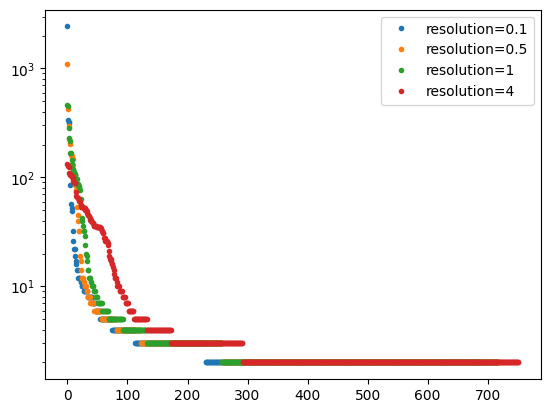

In [14]:
# community detection using louvain algorithm
fig, ax= plt.subplots()
for res in tqdm([0.1, 0.5, 1, 4]):
    communities = nx.community.louvain_communities(g_scrambled, resolution=res)
    sizes = [len(c) for c in communities]
    sizes.sort(key=lambda x: -x)
    ax.plot(range(len(sizes)), sizes, '.', label=f'resolution={res}')
    # assign `community_{res}` attribute to the nodes
    for i, c in enumerate(communities):
        for n in c:
            g_scrambled.nodes[n][f'community_{res:.2f}'] = f'community@{res:.2f}_{i:03d}'
ax.legend()
ax.set_yscale('log')


What we see is that the larger the `resolution` parameter of the Louvain algorithm, the larger the communities that are detected. This is because the resolution parameter controls the trade-off between the size of the communities and the number of communities. A larger resolution parameter will result in fewer, larger communities, while a smaller resolution parameter will result in more, smaller communities.


We will use this use this information to count the fraction of neighbors that are in the same community as the node itself. We will repeat this for different values of the resolution parameter and use this as a feature for the classifier.

In [15]:
def compute_community_features(g)->pd.DataFrame:
    # about 1 minute of computation time
    resolutions = np.round(np.linspace(0.01, 4, 10), 2)
    for res in tqdm(resolutions):
        communities = nx.community.louvain_communities(g_scrambled, resolution=res)
        sizes = [len(c) for c in communities]
        sizes.sort(key=lambda x: -x)
        ax.plot(range(len(sizes)), sizes, '.', label=f'resolution={res}')
        # assign `community_{res}` attribute to the nodes
        for i, c in enumerate(communities):
            for n in c:
                g_scrambled.nodes[n][f'community_{res:.2f}'] = f'community@{res:.2f}_{i:03d}'
                
    ret = []
    for n in g.nodes:
        neighbors = set(g.neighbors(n))
        curr = {'node_id': n}
        for res in (resolutions):
            community_this = g.nodes[n][f'community_{res:.2f}']
            neighbors_in_community = [g.nodes[nb][f'community_{res:.2f}'] == community_this for nb in neighbors]
            neighboring_communities = set([g.nodes[nb][f'community_{res:.2f}'] for nb in neighbors])
            n_neighboring_communities = len(neighboring_communities)
            curr[f'same_community@{res:.2f}'] = sum(neighbors_in_community) / len(neighbors)
            curr[f'n_neighboring_communities@{res:.2f}'] = n_neighboring_communities
        ret.append(curr)
    df_community_fraction = pd.DataFrame(ret).set_index('node_id')
    cols_same = [c for c in df_community_fraction.columns if 'same_community' in c]
    cols_neighboring = [c for c in df_community_fraction.columns if 'n_neighboring' in c]
    mean_same = df_community_fraction[cols_same].mean(axis=1)
    mean_neighboring = df_community_fraction[cols_neighboring].mean(axis=1)
    df_community_fraction['mean_same'] = mean_same
    df_community_fraction['mean_neighboring'] = mean_neighboring
    for perc in [10, 25, 75, 90]:
        df_community_fraction[f'percentile_same_{perc}'] = df_community_fraction[cols_same].apply(lambda x: np.percentile(x, perc), axis=1)
        df_community_fraction[f'percentile_neighboring_{perc}'] = df_community_fraction[cols_neighboring].apply(lambda x: np.percentile(x, perc), axis=1)
    
    return df_community_fraction
df_community_fraction = compute_community_features(g_scrambled)

  0%|          | 0/10 [00:00<?, ?it/s]

In [16]:
import time
def compute_ego_graph_features(g):
    vals = []
    start = time.time()
    for n in tqdm(g.nodes, desc='Ego-related features', total=len(g.nodes)):
        ego = nx.ego_graph(g_scrambled, n, radius=1)
        ego_no_self = ego.copy()
        ego_no_self.remove_node(n)
        
        curr = dict(node_id=n)
        betweenness_ego = nx.betweenness_centrality(ego)
        curr['betweenness_ego'] = betweenness_ego[n]
        
        # closeness_ego = nx.closeness_centrality(ego)
        # curr['closeness'] = closeness_ego[n]
        
        # clustering_before = nx.average_clustering(ego)
        # clustering_after = nx.average_clustering(ego_no_self)
        # curr['delta_clustering'] = clustering_after - clustering_before
        
        # diameter_before = nx.diameter(ego)
        # try:
        #     diameter_after = nx.diameter(ego_no_self)
        # except nx.NetworkXError:
        #     diameter_after =  len(ego_no_self.nodes)
        # curr['delta_diameter'] = diameter_after - diameter_before
        
        curr['n_components_no_self'] = nx.number_connected_components(ego_no_self)
        density_before = nx.density(ego)
        density_after = nx.density(ego_no_self)
        curr['delta_density'] = density_after - density_before
        vals.append(curr)
    return pd.DataFrame(vals).set_index('node_id')
df_egograph_features = compute_ego_graph_features(g_scrambled)

Ego-related features:   0%|          | 0/5793 [00:00<?, ?it/s]

In [17]:
df_all = pd.concat([
    df_egograph_features, 
    df_centrality_features, 
    df_community_fraction
], axis=1)
y = np.array(['scrambled' in i for i in df_community_fraction.index])
print(f'{df_all.shape=}, {y.mean()=:.3f}')

df_all.shape=(5793, 35), y.mean()=0.005


In [18]:

imbalance = y.sum() / len(y)
weights = np.ones_like(y, dtype=float)
weights[y] = 100

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    df_all, 
    y, 
    weights, 
    test_size=0.2, 
    random_state=42
)

# Initialize the CatBoost classifier
classifier = CatBoostClassifier(
    iterations=1000,
    learning_rate=1e-4,
    depth=8,  
    loss_function='Logloss',
    eval_metric='AUC',
    early_stopping_rounds=150,  # Early stopping
    l2_leaf_reg=10,  # L2 regularization
    subsample=0.8,  # Subsample fraction
    verbose=True,
)
# Fit the model with sample weights
classifier.fit(X_train, y_train, sample_weight=weights_train, eval_set=(X_test, y_test), plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8250218	best: 0.8250218 (0)	total: 59.6ms	remaining: 59.5s
1:	test: 0.8533507	best: 0.8533507 (1)	total: 62.3ms	remaining: 31.1s
2:	test: 0.8798085	best: 0.8798085 (2)	total: 65.4ms	remaining: 21.7s
3:	test: 0.8734987	best: 0.8798085 (2)	total: 68.9ms	remaining: 17.1s
4:	test: 0.8674064	best: 0.8798085 (2)	total: 70.4ms	remaining: 14s
5:	test: 0.8589208	best: 0.8798085 (2)	total: 73.9ms	remaining: 12.2s
6:	test: 0.8603133	best: 0.8798085 (2)	total: 76.9ms	remaining: 10.9s
7:	test: 0.8548738	best: 0.8798085 (2)	total: 79.7ms	remaining: 9.88s
8:	test: 0.8536554	best: 0.8798085 (2)	total: 83.8ms	remaining: 9.23s
9:	test: 0.8536989	best: 0.8798085 (2)	total: 88.3ms	remaining: 8.74s
10:	test: 0.8555265	best: 0.8798085 (2)	total: 91.6ms	remaining: 8.24s
11:	test: 0.8546562	best: 0.8798085 (2)	total: 95.1ms	remaining: 7.83s
12:	test: 0.8531767	best: 0.8798085 (2)	total: 98.1ms	remaining: 7.45s
13:	test: 0.8657963	best: 0.8798085 (2)	total: 101ms	remaining: 7.11s
14:	test: 0.8682332

Matthews correlation coefficient: 0.07
Of the  75 nodes predicted as scrambled,      2.7% are actually scrambled
Of the 7  nodes that are actually scrambled, 28.6% are predicted as scrambled


Text(0.5, 1.02, 'Prediction performance on the partial dataset')

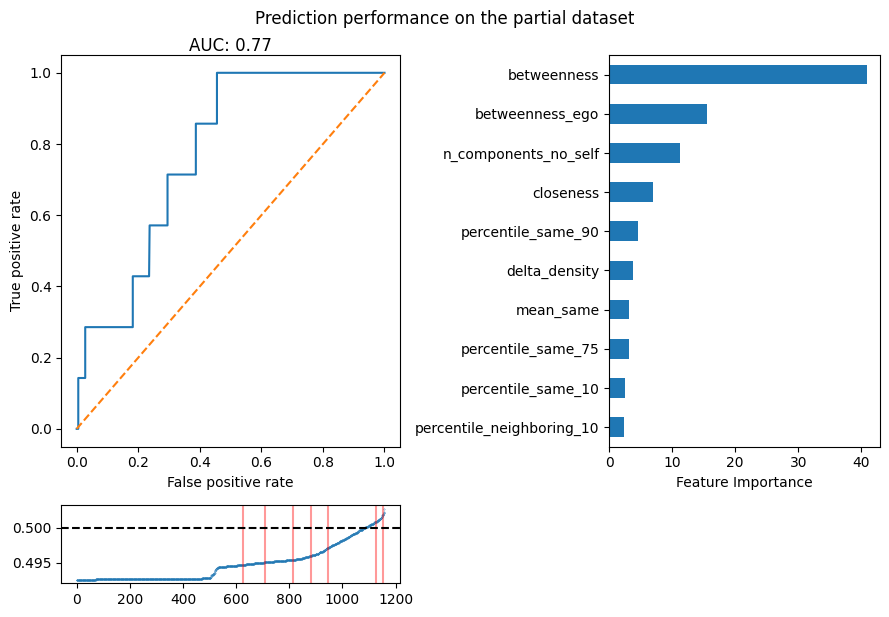

In [38]:
from sklearn.metrics import roc_curve, auc


def prediction_performance(X_test, y_test, classifier):
    # Predict and evaluate if needed
    y_pred = classifier.predict(X_test)
    p_pred_proba = classifier.predict_proba(X_test)[:, 1]
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f'Matthews correlation coefficient: {mcc:.2f}')
    precision = 100 * np.sum(y_test & y_pred) / np.sum(y_pred)
    recall = 100 * np.sum(y_test & y_pred) / np.sum(y_test)
    print(f'Of the {y_pred.sum():3,d} nodes predicted as scrambled,      {precision:.1f}% are actually scrambled')
    print(f'Of the {y_test.sum():,d}  nodes that are actually scrambled, {recall:.1f}% are predicted as scrambled')
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 6), height_ratios=[5, 1], width_ratios=[5, 4])
    ax = axes[0,0]
    # roc curve
    fpr, tpr, _ = roc_curve(y_test, p_pred_proba)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], linestyle='--')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    auc_score = auc(fpr, tpr)
    ax.set_title(f'AUC: {auc_score:.2f}', va='top')
    
    ax = axes[1, 0]
    lix= np.argsort(p_pred_proba)
    ax.plot(p_pred_proba[lix], '.', ms=0.5)
    y_test_sorted = y_test[lix]
    for i in range(len(y_test_sorted)):
        if y_test_sorted[i]:
            ax.axvline(i, color='red', alpha=0.4)
    ax.axhline(0.5, color='black', linestyle='--')
    
    ax = axes[0, 1]
    # feature importance
    try:
        feature_importance = classifier.get_feature_importance(prettified=True).head(10).iloc[::-1]
        feature_importance.plot.barh(x='Feature Id', y='Importances', legend=False, ax=ax)
        ax.set_ylabel('')
        ax.set_xlabel('Feature Importance')
    except:
        ax.axis('off')
    
    ax = axes[1, 1]
    # turn off
    ax.axis('off')
    fig.tight_layout()
    
    
    
prediction_performance(X_test, y_test, classifier)    
fig = plt.gcf()
fig.suptitle('Prediction performance on the partial dataset', y=1.02)

Now, let's load the full dataset

In [39]:
df_full = pd.read_csv('ca-HepPh_disambiguation_features.csv').set_index('index', drop=True)
cols = ['betweenness_ego', 'n_components_no_self', 'delta_density','betweenness', 'closeness', 'mean_same', 'mean_neighboring', 'percentile_same_10', 'percentile_same_25', 'percentile_same_75', 'percentile_same_90', 'percentile_neighboring_10', 'percentile_neighboring_25', 'percentile_neighboring_75', 'percentile_neighboring_90']
print(f'{df_full.shape=}')
df_full = df_full[cols]

df_full.shape=(5793, 36)


In [40]:
y = np.array(['scrambled' in i for i in df_full.index])
weights = np.ones_like(y, dtype=float)
weights[y] = 100
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    df_full, 
    y, 
    weights, 
    test_size=0.2, 
    random_state=42
)
classifier = CatBoostClassifier(
    iterations=1000,
    learning_rate=1e-5,
    depth=12,  
    loss_function='Logloss',
    eval_metric='AUC',
    early_stopping_rounds=150,  # Early stopping
    l2_leaf_reg=10,  # L2 regularization
    subsample=0.8,  # Subsample fraction
    verbose=True,
)
classifier.fit(X_train, y_train, sample_weight=weights_train, eval_set=(X_test, y_test), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6480035	best: 0.6480035 (0)	total: 88.4ms	remaining: 1m 28s
1:	test: 0.6982267	best: 0.6982267 (1)	total: 114ms	remaining: 56.9s
2:	test: 0.6456473	best: 0.6982267 (1)	total: 138ms	remaining: 45.9s
3:	test: 0.6484375	best: 0.6982267 (1)	total: 141ms	remaining: 35s
4:	test: 0.6573661	best: 0.6982267 (1)	total: 160ms	remaining: 31.9s
5:	test: 0.7271205	best: 0.7271205 (5)	total: 177ms	remaining: 29.3s
6:	test: 0.7181300	best: 0.7271205 (5)	total: 198ms	remaining: 28s
7:	test: 0.7232143	best: 0.7271205 (5)	total: 213ms	remaining: 26.4s
8:	test: 0.7238963	best: 0.7271205 (5)	total: 232ms	remaining: 25.5s
9:	test: 0.7266245	best: 0.7271205 (5)	total: 253ms	remaining: 25.1s
10:	test: 0.7147197	best: 0.7271205 (5)	total: 277ms	remaining: 24.9s
11:	test: 0.7415675	best: 0.7415675 (11)	total: 303ms	remaining: 24.9s
12:	test: 0.7475818	best: 0.7475818 (12)	total: 329ms	remaining: 25s
13:	test: 0.7502480	best: 0.7502480 (13)	total: 350ms	remaining: 24.7s
14:	test: 0.7537202	best: 0.753

Matthews correlation coefficient: 0.07
Of the  75 nodes predicted as scrambled,      2.7% are actually scrambled
Of the 7  nodes that are actually scrambled, 28.6% are predicted as scrambled


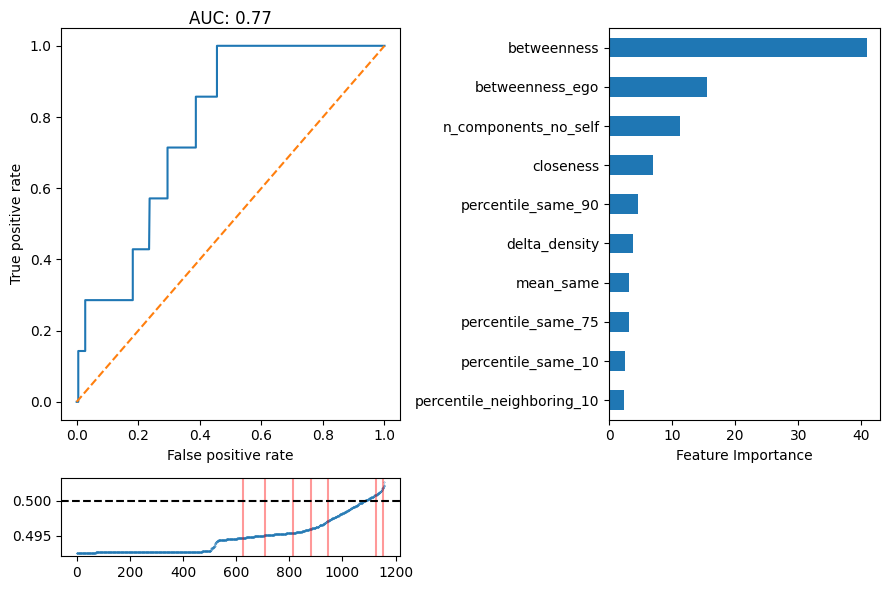

In [41]:
prediction_performance(X_test, y_test, classifier)

Matthews correlation coefficient: 0.00
Of the   0 nodes predicted as scrambled,      nan% are actually scrambled
Of the 7  nodes that are actually scrambled, 0.0% are predicted as scrambled
Matthews correlation coefficient: 0.00
Of the   0 nodes predicted as scrambled,      nan% are actually scrambled
Of the 7  nodes that are actually scrambled, 0.0% are predicted as scrambled


/var/folders/xy/6n3m38qx423b_gjbx89x02b40000gn/T/ipykernel_97680/3523838157.py:10: RuntimeWarning: invalid value encountered in scalar divide
  precision = 100 * np.sum(y_test & y_pred) / np.sum(y_pred)
/var/folders/xy/6n3m38qx423b_gjbx89x02b40000gn/T/ipykernel_97680/3523838157.py:10: RuntimeWarning: invalid value encountered in scalar divide
  precision = 100 * np.sum(y_test & y_pred) / np.sum(y_pred)


Text(0.5, 1.02, 'Random classifier')

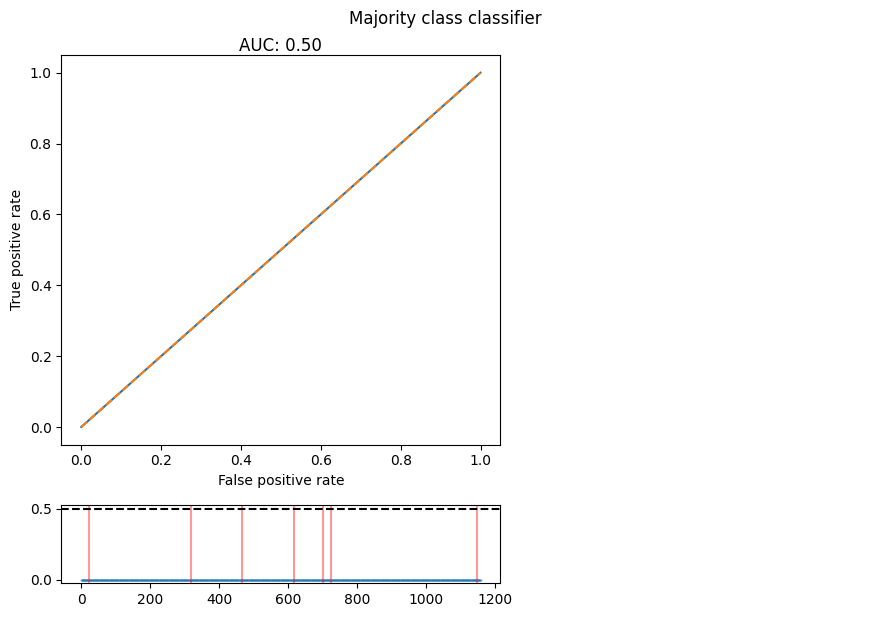

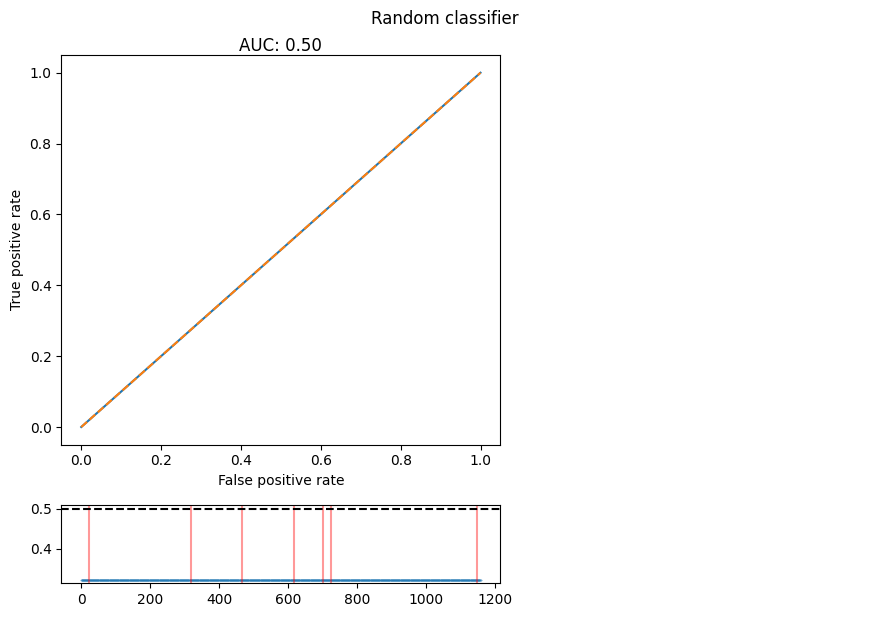

In [43]:
# for the purpose of performance comparison, we will use a majority class classifier and a random classifier
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train, sample_weight=weights_train)
prediction_performance(X_test, y_test, dummy)
fig = plt.gcf()
fig.suptitle('Majority class classifier', y=1.02)
dummy = DummyClassifier(strategy='prior')
dummy.fit(X_train, y_train, sample_weight=weights_train)
prediction_performance(X_test, y_test, dummy)
fig = plt.gcf()
fig.suptitle('Random classifier', y=1.02)

In [44]:
nx.graph_atlas?

In [46]:
nx.graph_atlas_g?

In [48]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.metrics import classification_report

# Convert NetworkX graph to PyTorch Geometric Data object
def networkx_to_pyg_data(G):
    edge_index = torch.tensor(list(G.edges)).t().contiguous()
    x = torch.eye(G.number_of_nodes())  # One-hot encoding for each node
    y = torch.tensor([G.nodes[node].get('label', False) for node in G.nodes()], dtype=torch.long)
    data = Data(x=x, edge_index=edge_index, y=y)
    return data


def try_torch(G):
    
    data = networkx_to_pyg_data(G)
    data.train_mask = torch.rand(len(data.y)) < 0.8  # 80% train, 20% test
    data.test_mask = ~data.train_mask
    
    # Define GCN model
    class GCN(torch.nn.Module):
        def __init__(self):
            super(GCN, self).__init__()
            self.conv1 = GCNConv(data.num_node_features, 16)
            self.conv2 = GCNConv(16, 2)  # Assuming binary classification
    
        def forward(self, data):
            x, edge_index = data.x, data.edge_index
            x = self.conv1(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, training=self.training)
            x = self.conv2(x, edge_index)
            return F.log_softmax(x, dim=1)
    
    # Train the GCN model
    device = torch.device('cpu')
    model = GCN().to(device)
    data = data.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    
    model.train()
    for epoch in range(200):
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
    
    # Evaluate the GCN model
    model.eval()
    _, pred = model(data).max(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    accuracy = int(correct) / int(data.test_mask.sum())
    print('Accuracy: {:.4f}'.format(accuracy))

ModuleNotFoundError: No module named 'torch_geometric'